In [66]:
%matplotlib inline

# libraries for imbalanced learning
from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE,KMeansSMOTE, ADASYN
from fma_metadata import utils
import pandas as pd
import numpy as np
import sys

PATH = '/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2'
sys.path.insert(0, PATH) 

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score,precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Librosa features - IMBALANCED LEARNING
## 1. Premise
The hyper-parameters and results for unbalanced classifiers are taken  from the notebooks:
- bin-genre_decision-tree_KNN  (section 2)



__________________________________
# 2 Multi genre classification
__________________________________
## a) Import dataset

In [7]:
multiclass_dataset = utils.load('/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/features.csv')
# Import genre_labels dataset
labels = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Labels/genre_labels.csv')
labels=labels.set_index('track_id')

# Merging genre_top with librosa
multiclass_dataset = multiclass_dataset.merge(labels, on='track_id')
multiclass_dataset.head()

,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)","(chroma_cens, kurtosis, 10)",...,"(tonnetz, std, 05)","(tonnetz, std, 06)","(zcr, kurtosis, 01)","(zcr, max, 01)","(zcr, mean, 01)","(zcr, median, 01)","(zcr, min, 01)","(zcr, skew, 01)","(zcr, std, 01)",genre_top
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.0,2.089872,0.061448,Hip-Hop
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.0,1.716724,0.069330,Hip-Hop
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.0,2.193303,0.044861,Hip-Hop
10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,...,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.0,3.542325,0.040800,Pop
134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.0,1.806106,0.054623,Hip-Hop


In [8]:
# drop duplicates
print(f"shape before removing duplicates: {multiclass_dataset.shape}")
multiclass_dataset.drop_duplicates(keep=False, inplace=True)
print(f"shape after removing duplicates: {multiclass_dataset.shape}")

shape before removing duplicates: (49598, 519)
shape after removing duplicates: (48754, 519)


In [9]:
# drop NaN
multiclass_dataset.dropna(inplace=True)
multiclass_dataset.isnull().sum()

(chroma_cens, kurtosis, 01)    0
(chroma_cens, kurtosis, 02)    0
(chroma_cens, kurtosis, 03)    0
(chroma_cens, kurtosis, 04)    0
(chroma_cens, kurtosis, 05)    0
                              ..
(zcr, median, 01)              0
(zcr, min, 01)                 0
(zcr, skew, 01)                0
(zcr, std, 01)                 0
genre_top                      0
Length: 519, dtype: int64

In [10]:
print(f"shape after removing null values: {multiclass_dataset.shape}")

shape after removing null values: (48754, 519)


In [11]:
# Select top 8 genres
genres_subset = ['Rock','Electronic','Hip-Hop','Folk','Old-Time / Historic','Pop',
          'Classical','Jazz']

# generating dataset for multiclass classification task
multiclass_dataset = multiclass_dataset[multiclass_dataset['genre_top'].isin(genres_subset)]

In [12]:
# check class distribution in %
pd.concat([multiclass_dataset.genre_top.value_counts(),
                round(multiclass_dataset.genre_top.value_counts(normalize=True).mul(100),2)],
          axis=1,
          keys=('counts','percentage (%)'))

,counts,percentage (%)
Rock,14073,41.40
Electronic,9009,26.50
Hip-Hop,3470,10.21
Folk,2778,8.17
Pop,2324,6.84
Classical,1222,3.59
Jazz,563,1.66
Old-Time / Historic,554,1.63


In [13]:
# encoding labels
le = preprocessing.LabelEncoder()
multiclass_dataset['genre_top'] = le.fit_transform(multiclass_dataset['genre_top'])
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock')
multiclass_dataset.genre_top.value_counts()

Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock


7    14073
1     9009
3     3470
2     2778
6     2324
0     1222
4      563
5      554
Name: genre_top, dtype: int64

In [14]:
# detach target col
labels = multiclass_dataset[['genre_top']]
labels.reset_index(drop=True, inplace=True)
labels = labels['genre_top']

In [15]:
multiclass_dataset.drop('genre_top', axis=1, inplace=True)

In [16]:
# normalize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(multiclass_dataset)

[]

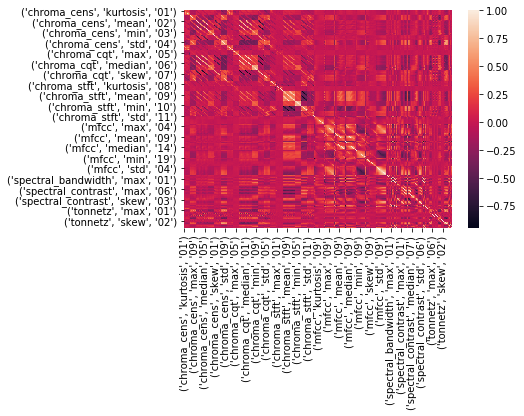

In [17]:
# correlation matrix
corr = multiclass_dataset.corr()
sns.heatmap(corr)
plt.plot()


## b) Compute PCA and plot distribution in 2D

In [18]:
# compute PCA using optimal number of components: 8 ( discovered in the notebook mentioned above)
pca = PCA(154,random_state=10)
pca.fit(scaled_features)
X_pca = pca.transform(scaled_features)

In [19]:
# split data in development and internal test
X, X_test, y, y_test = train_test_split(X_pca, labels, test_size=0.30, random_state=10, stratify=labels)

In [20]:
# development set shape
X.shape, y.shape

((23795, 154), (23795,))

In [21]:
# internal test shape
X_test.shape, y_test.shape

((10198, 154), (10198,))

In [22]:
# check partitions
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\
\n7: Rock'\n\n***PCA***\nDevelopment set:\n{y.value_counts()}\n{len(y)}\n\nInternal Test:\
\n{y_test.value_counts()}\n{len(y_test)}\n\n\-----------------")


____Legend_____
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock'

***PCA***
Development set:
7    9851
1    6306
3    2429
2    1945
6    1627
0     855
4     394
5     388
Name: genre_top, dtype: int64
23795

Internal Test:
7    4222
1    2703
3    1041
2     833
6     697
0     367
4     169
5     166
Name: genre_top, dtype: int64
10198

\-----------------


In [23]:
print('Class distribution before balancing after splitting in train test')
pd.concat(
    [y.value_counts(),
                round(y.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)


Class distribution before balancing after splitting in train test


,counts,percentage (%)
7,9851,41.40
1,6306,26.50
3,2429,10.21
2,1945,8.17
6,1627,6.84
0,855,3.59
4,394,1.66
5,388,1.63


In [24]:
# function for plotting data in 2D with PCA
def pca_2D(X, y, graph_title):
    """
    This function plots in 2D the features of X.
    :param X: array of features
    :param y: labels
    :param graph_title: title to be displayed on the graph
    :return: 2D scatter-plot
    """
    # dataframe for plotting PCA
    df = pd.DataFrame()
    df['pca1'] = X[:,0]
    df['pca2'] = X[:,1]
    df['genres'] = le.inverse_transform(y)
    # plot scatter of PCA
    plt.figure(figsize=(10,7))
    sns.scatterplot(
        x="pca1", y="pca2",
        hue='genres',
        data=df,
        palette={'Jazz':'mediumorchid','Rock':'forestgreen', 'Hip-Hop':'dodgerblue',
                 'Pop':'darkorange', 'Electronic':'saddlebrown','Old-Time / Historic':'grey',
                 'Folk':'crimson', 'Classical':'violet'},
        legend="full",
        alpha=0.8
    )
    plt.title(graph_title, fontsize= 15)
    plt.show()

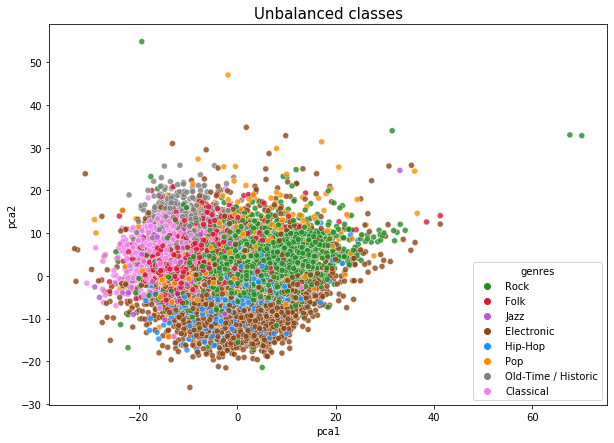

In [25]:
pca_2D(X, y,'Unbalanced classes')

## c) Imbalanced learning:
#### c.1) Undersampling - Random

In [26]:
under_sample = RandomUnderSampler(random_state=42)
# Store under-sampled data
X_under, y_under = under_sample.fit_resample(X,y)

In [27]:
print('Class distribution after Random Undersampling:')
y_under.value_counts()

Class distribution after Random Undersampling:


0    388
2    388
4    388
6    388
1    388
3    388
5    388
7    388
Name: genre_top, dtype: int64

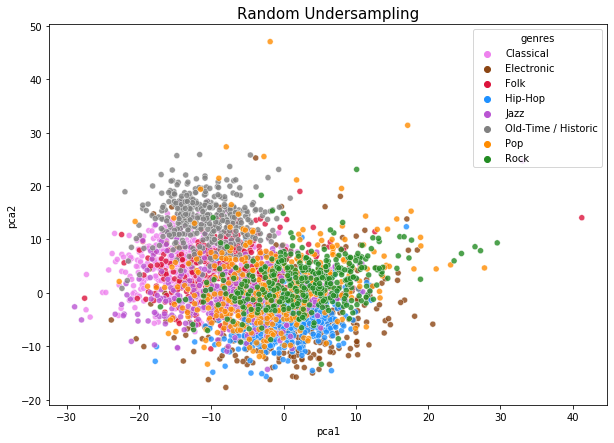

In [28]:
pca_2D(X_under,y_under,'Random Undersampling')

#### c.2) Condensed Nearest Neighbor (CNN)

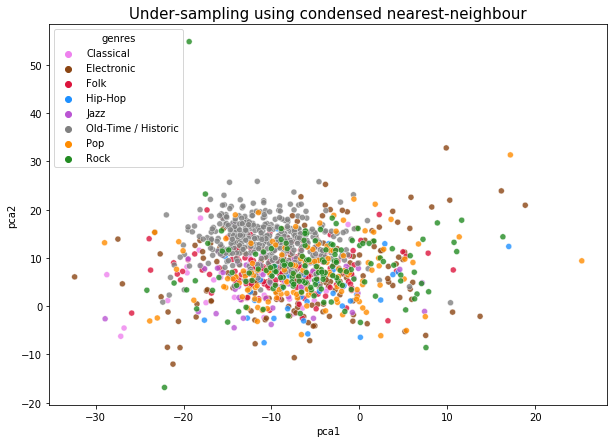

In [29]:
# Apply Condensed Nearest Neighbours
cnn = CondensedNearestNeighbour()
X_cnn, y_cnn = cnn.fit_resample(X, y)
#X_res_vis = pca.transform(X_resampled)
pca_2D(X_cnn,y_cnn,'Under-sampling using condensed nearest-neighbour')

#### c.3) Tomek's Link

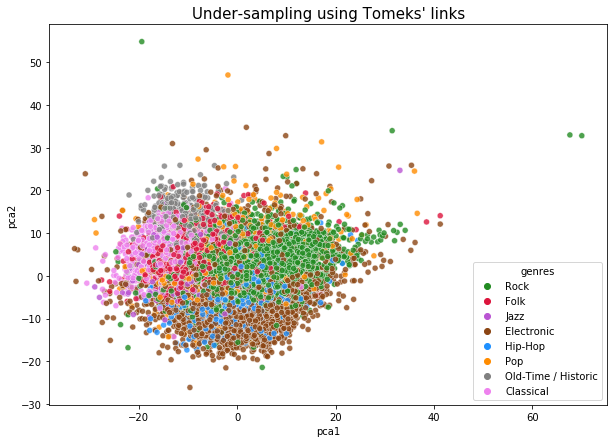

In [30]:
tomeks = TomekLinks()
X_tomek, y_tomek = tomeks.fit_resample(X, y)

pca_2D(X_tomek, y_tomek, 'Under-sampling using Tomeks\' links')

#### c.4) Oversampling - Random

In [31]:
over_sample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = over_sample.fit_resample(X, y)

In [32]:
X_over.shape, y_over.shape

((33258, 154), (33258,))

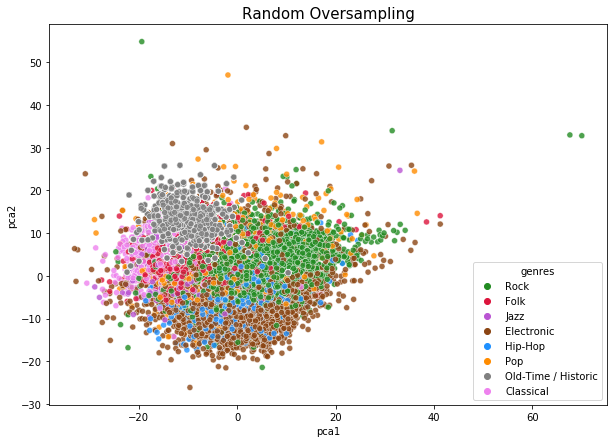

In [33]:
pca_2D(X_over, y_over, 'Random Oversampling')

#### c.5) SMOTE

In [34]:
smote_over = SMOTE()
X_smote, y_smote = smote_over.fit_resample(X, y)
X_smote.shape, y_smote.shape

((78808, 154), (78808,))

In [35]:
y_smote.value_counts()

0    9851
1    9851
2    9851
3    9851
4    9851
5    9851
6    9851
7    9851
Name: genre_top, dtype: int64

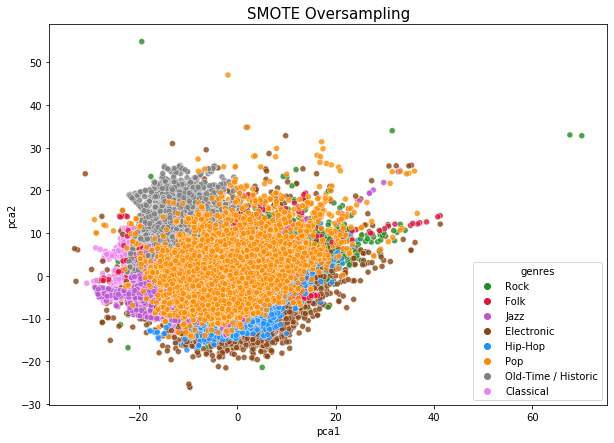

In [36]:
pca_2D(X_smote, y_smote, 'SMOTE Oversampling')

#### K-Means SMOTE

In [60]:
ksmote = KMeansSMOTE(random_state=42, sampling_strategy='not majority',kmeans_estimator=10, k_neighbors=5)
X_ksmote, y_ksmote = ksmote.fit_resample(X, y)

In [61]:
y_ksmote.value_counts()

1    9859
2    9854
3    9854
6    9854
0    9852
4    9851
5    9851
7    9851
Name: genre_top, dtype: int64

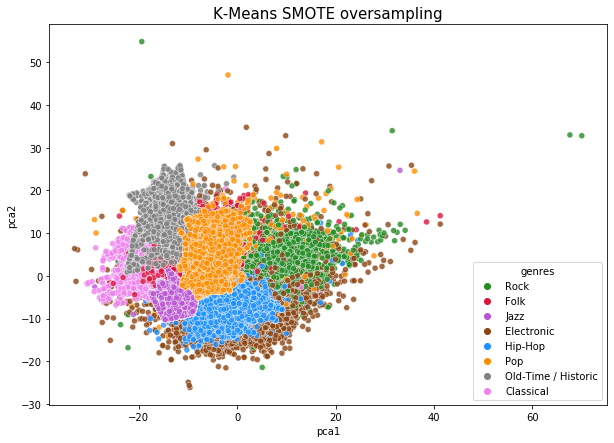

In [62]:
pca_2D(X_ksmote, y_ksmote, "K-Means SMOTE oversampling")

#### c.6) ADASYN

In [49]:
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

In [50]:
y_adasyn.value_counts()

2    9986
3    9980
0    9876
6    9856
7    9851
5    9848
4    9805
1    9666
Name: genre_top, dtype: int64

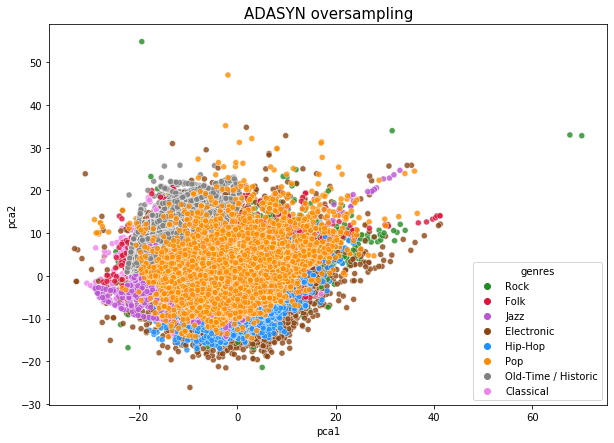

In [51]:
pca_2D(X_adasyn, y_adasyn, "ADASYN oversampling")

#### c.7) Class Weight

#### c.8) Ensamble (** not in the program)

_____________________________________________________________________________________________________________________

## d) Decision tree

We need to do a grid search after we balanced our data. We cannot use the hyperparameters found on an unbalanced dataset, because those were biased by the fact that they aimed at maximizing the overall accuracy. <br>
We cannot run a grid search with the oversampled data either, because we will then have a validation set containing synthetic data.<br>
What we can do it to use **pipeline** which will oversample only the training data (leaving the validaiton data i.e. fold, unbalanced). This will be done iteretavely.<br>
#### Grid-Search 

In [ ]:
from imblearn.pipeline import make_pipeline, Pipeline

# search parameters
param_grid = {
               "class__max_depth": [5,10],                     # the class__  tells pipeline to which obj 
               "class__min_samples_leaf": [10,30,55],       # the param refers to
               "class__min_samples_split": [10,50],
               "class__criterion": ["gini","entropy"]
             }

balancing_techniques=[under_sample, tomeks, over_sample, smote_over, ksmote, adasyn]

# instantiate a model
dtc = DecisionTreeClassifier()

for samp_algo in balancing_techniques:
    pipeline = Pipeline([('balancing', samp_algo), ('class', dtc)])
    #rep_kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)

    clf = GridSearchCV(pipeline, cv =5 , param_grid=param_grid, n_jobs=3, verbose=True)
    clf.fit(X, y)
    print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    8.0s
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:   23.7s finished


best parameters:
{'class__criterion': 'entropy', 'class__max_depth': 5, 'class__min_samples_leaf': 10, 'class__min_samples_split': 50}
accuracy: 0.4944736289136372
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


### d.2) Unbalanced vs Balanced

In [85]:
data =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-Means SMOTE','ADASYN' ]

for bal_data,title in zip(data,titles):
    dt = DecisionTreeClassifier(criterion= 'gini',max_depth=10, min_samples_leaf= 55,min_samples_split=10)
    dt.fit(bal_data[0],bal_data[1])
    y_pred = dt.predict(X_test)

    print(f"*** {title} classification ***")
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    #print('Recall %s' % recall_score(y_test, y_pred, average=None))
    #print('Precision %s' % precision_score(y_test, y_pred,average=None))
    print(classification_report(y_test, y_pred))

*** unbalanced classification ***
Accuracy 0.6142380858991959
F1-score [0.60526316 0.59537572 0.45341615 0.40958606 0.06091371 0.65697674
 0.05771644 0.75938835]

              precision    recall  f1-score   support

           0       0.54      0.69      0.61       367
           1       0.55      0.65      0.60      2703
           2       0.47      0.44      0.45       833
           3       0.47      0.36      0.41      1041
           4       0.21      0.04      0.06       169
           5       0.63      0.68      0.66       166
           6       0.23      0.03      0.06       697
           7       0.72      0.80      0.76      4222

    accuracy                           0.61     10198
   macro avg       0.48      0.46      0.45     10198
weighted avg       0.58      0.61      0.59     10198

*** undersampling classification ***
Accuracy 0.4676407138654638
F1-score [0.56772674 0.4596882  0.37314254 0.4126871  0.13656388 0.45619835
 0.11984172 0.63534676]

              precis

In [53]:
# classification with cost matrix
dt_w = DecisionTreeClassifier(criterion= 'gini',max_depth=5, min_samples_leaf= 20, min_samples_split=10, class_weight='balanced')
dt_w.fit(X, y)
y_pred_w = dt_w.predict(X_test)
print(f"*** cost-matrix classification ***")
print('Accuracy %s' % accuracy_score(y_test, y_pred_w))
print('F1-score %s\n' % f1_score(y_test, y_pred_w, average=None))
print(classification_report(y_test, y_pred_w))

*** cost-matrix classification ***
Accuracy 0.4640125514806825
F1-score [0.5994898  0.45859586 0.36869565 0.39209877 0.17351598 0.52953157
 0.15235792 0.63983669]

              precision    recall  f1-score   support

           0       0.56      0.64      0.60       367
           1       0.59      0.38      0.46      2703
           2       0.26      0.64      0.37       833
           3       0.40      0.38      0.39      1041
           4       0.14      0.22      0.17       169
           5       0.40      0.78      0.53       166
           6       0.11      0.27      0.15       697
           7       0.83      0.52      0.64      4222

    accuracy                           0.46     10198
   macro avg       0.41      0.48      0.41     10198
weighted avg       0.60      0.46      0.50     10198



## d) KNN

### Unbalanced vs Balanced

In [64]:
data =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-Means SMOTE','ADASYN' ]

for bal_data,title in zip(data,titles):
    knn = KNeighborsClassifier(n_neighbors = 10, weights='distance')
    knn.fit(bal_data[0],bal_data[1])
    y_pred = knn.predict(X_test)

    print(f"*** {title} classification ***")
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))


*** unbalanced classification ***
Accuracy 0.6959207687781918
F1-score [0.77892031 0.65292842 0.55597015 0.62735849 0.4738676  0.92168675
 0.15837104 0.79492687]

              precision    recall  f1-score   support

           0       0.74      0.83      0.78       367
           1       0.79      0.56      0.65      2703
           2       0.58      0.54      0.56       833
           3       0.62      0.64      0.63      1041
           4       0.58      0.40      0.47       169
           5       0.92      0.92      0.92       166
           6       0.37      0.10      0.16       697
           7       0.70      0.92      0.79      4222

    accuracy                           0.70     10198
   macro avg       0.66      0.61      0.62     10198
weighted avg       0.69      0.70      0.67     10198

*** undersampling classification ***
Accuracy 0.531182584820553
F1-score [0.67706013 0.31523334 0.4954955  0.50031309 0.17446809 0.81794195
 0.18253968 0.74705882]

              precisi